<h1><center> Group Assignment - CS985 - Machine Learning for Data Analytics </center></h1>

<h1><center>Project Notebook - Team Y</center></h1>

<h1><center>Kanaada MNIST Classification</center></h1>

-----------------------

<h1><ins>1 - Introduction</ins></h1><br>




<h2>1.1 - The Team</h2>



All members are studying the MSc Artificial Intelligence and Applications:

| Name           | Student Number | Kaggle ID                             |
| -------------- | -------------- | ------------------------------------- |
| James Dutfield | 201977849      | <https://www.kaggle.com/dutters>      |
| Frank Mitchell | 201957720      | <https://www.kaggle.com/fmitchell259> |
| Kanaad Pathak  | 201964344      | <https://www.kaggle.com/kanaadpathak> |
| Barry Smart    | 201962939      | <https://www.kaggle.com/vesperpiano>  |

-----------------------------------

<h2>1.2 - Tooling</h2>

We used the following tools to support team working:

![Illustration of tools used to coordinate team and manage code.](images/tools.png)


<h2>1.3 - High Level Architecture</h2>

We adhered to the following high level architecutre:

![Illustration of the high level data flows and architecture.](images/architecture.png)

<h2>1.4 - Import Libraries</h2>

Import necessary libraries. 



In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
from keras.layers import LeakyReLU
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import reciprocal
import sys
import os
import scipy
import time
sys.path.insert(0, "../")
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

------------

<h1><ins>2 - Data Preprocessing</ins></h1><br>


In terms of data pre-processing, the steps taken for MNIST were comparitively minimal. It was important that the features were scaled properly, as neural networks use the weighted sum of inputs for training, so for the network to be stable and train effectively, weights must be kept small. 

<br>

<h2>2.1 - Pixel Scaling Methods</h2><br>

There are three main approaches when it comes to scaling pixels:<br>

1. <i>Normalisation:</i> Pixels are scaled to the range 0-1.<br>

2. <i>Centering:</i> The mean value is subtracted from each pixel, resulting in a distribution of pixel values centered around a mean of zero. 

3. <i>Standardisation:</i> Pixel values are scaled to a standard Gaussian with a mean of zero and a standard deviation of one. 

As a means of initial exploration we chose to `Normalise` the pixels. This is often the default approach, working on the assumption that pixel values are always in the range of 0-255, making it very simple and efficient to scale in this manner. 

Centering is also a popular approach for scaling, but can add further levels of complexity, as the `mean` can be calculated per image (globally) or per channel (locally) and across a batch of images or the entire dataset. 

For our first approach we thought it prudent to move forward with the simplest method of data normalisation. 

We normalise all the data and split the training set into `training` and `validation`, dropping the `Id` and `Label` columns in the process. 

Finally, we converted the data into `2d numpy arrays` to use as input for our Neural Networks.

---

    
    
  



In [3]:
training_data = pd.read_csv('data/kannada_mnist/training.csv')
testing_data = pd.read_csv('data/kannada_mnist/test.csv')

X_train_full = training_data.drop(columns=['label', 'id'])
y_train_full = training_data['label']


X_valid, X_train = X_train_full[:1000] / 255.0, X_train_full[1000:] / 255.0
y_valid, y_train = y_train_full[:1000], y_train_full[1000:]

X_test = testing_data / 255.0

X_test = X_test.drop(columns=['id'])


In [4]:
X_train = pd.DataFrame.to_numpy(X_train)
X_test = pd.DataFrame.to_numpy(X_test)
X_valid = pd.DataFrame.to_numpy(X_valid)

y_train = pd.DataFrame.to_numpy(y_train)
y_valid = pd.DataFrame.to_numpy(y_valid)

<br>

<h2>2.2 - One Hot Encoding</h2><br>

The target variable is a range from `0-9`, and as such we conducted one-hot encoding, giving each individual neuron the option to fire (output `1`) or not (output `0`). 

To conduct this `one-hot encoding` we used numpy's built in `to_categorical` method. 

---





In [5]:
n_classes = 10
y_train_one_hot = np_utils.to_categorical(y_train, n_classes)
y_valid_one_hot = np_utils.to_categorical(y_valid, n_classes)

<br>

<h2>2.3 - Tensorboard Boiler Plate</h2><br>

This is boiler plate code required to access `Tensorboard` visualisations, setting up a root directory to hold `Tensorboard` files. 

These files are created using keras `callbacks` and accessed through a web browser. 

---





In [6]:
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_&d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

<br>

<h2>2.4 - GridSearchCV SKLearn Wrapper</h2><br>

In order to utilise SKLearn's `GridSearchCV` object we had to create a thin wrapper for our models. 

After achieving an acceptable baseline, we then used this wrapper to automatically optimise the hyperparameters. 

----





In [6]:
def build_model(n_hidden=3, learning_rate=0.01, n_neurons=512, input_shape=[784], dropout_rate=0.2, 
                loss="categorical_crossentropy", output_neurons=10, optimizer='sgd', activation='relu',
               momentum=0.9):
    
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
        model.add(keras.layers.Dropout(rate=dropout_rate))
    model.add(keras.layers.Dense(output_neurons, activation="softmax"))
    model.compile(loss=loss, optimizer='sgd', metrics=['accuracy'])

    
    return model

---

---

<h1><ins>3 - Classification Models</ins></h1><br>

<h2>3.1 - Simple Deep Neural Network</h2><br>

<h3><ins>3.1.1 - Introduction</ins></h3><br>

One of our first models aimed to reflect a simple architecture to achieve a baseline accuracy. Through consulation of the book `Hands On ML` by Geron, we decided on a simple two layer network using the `ReLU` activation function. As outlined by Geron, this function behaves much better in a neural net (as oppossed to the `sigmoid`) as it doesn't saturate gradients for positive values (and it's much faster to compute).

We considered the `dying ReLU's problem` (during training some neurons begin outputting only zero, causing gradient descent to have no effect because the gradient of the `ReLU` is zero when its input is negative). However, in keeping with our initial outline for a simple neural net, we moved forward with regular `ReLU`, with a view to comparing this with `Leaky ReLU` (a variation on regular `ReLU` that adds a small slope to avoid neurons from dying out altogether).

We also felt it suitable to include `Dropout` layers in our network to help avoid overfitting. `Dropout` will randomly set a percentage of outgoing edges (from hidden units) to be temporarily 'dropped out' during training (meaning they are ignored at this stage in the process), but could be activated again on the next step. This process can be highly destructive, however, according to Geron, is <i>"a proven method for adding 1-2% accuracy to some models".</i>  
    


---

<h3><ins>3.1.2 - Architecture</ins></h3><br>

![Illustration of SImple Deep Neural Network Architecture.](images/frank_arch1.png)


<br>

<h3><ins> 3.1.3 - Weight Initialisation</ins></h3><br>

Another important factor to consider in any neural network are the weight initialisations. As pointed out by `Glorot and He`, a signal must flow properly in both directions of the network (the forward pass and the back-propogation). It is detrimental to our network if these signals die out, or explode (and saturate the model).

`Glorot and He` argue that for a signal to flow properly we need the variance of the outputs of each layer to be equal to the variance of its inputs, and we need the gradient to have equal variance, before and after flowing through a layer in the reverse direction. 

We can only ensure both of these statements will be true by having an equal number of inputs and neurons (these are called the `fanIn` and `fanOut` values). 

However, `Glorot and He` have suggested a good compromise:

The connection weights of each layer must be initialised randomly, where:

`fanAverage = (fanIn + fanOut)/2`

This is known as the `Xavier Initialisation`. 

For our first model though, we opted for a slight variance on this technique called, `He Initialisation`, which provides a uniform distribution of weight values based on `favAverage` rather than `fanIn`. 

This weight initialisation is easily implemented using keras' `VarianceScaling`
initialiser. 

---


In [7]:
he_avg_init = keras.initializers.VarianceScaling(scale=2, mode='fan_avg',
                                                distribution='uniform')

<br>

<h3><ins>3.1.4 Implementation</ins></h3><br>

With out weight initialisation set up, and an architecture in mind, we went ahead and constructed the model using the keras `Sequential` object. 

This model was trained using the `adam` optimiser (Adaptive Moment Estimation). This optimser combines the idea of `momentum` (tracking an exponentially decaying average of past gradients) and `RMSProp`, another optimiser that keeps track of exponentially decaying average past square gradients. 

We chose `Adam` in adherence with our principle of simple execution. `Adam` is an adaptive learning rate algorithm, and as such requires very little tuning of hyperparameters. 

Accoring to `Geron`, this makes `Adam`, <i>"even easier to use than Gradient Descent."
</i>

<br>






In [8]:
model = keras.models.Sequential([

    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation='softmax')
    
])

model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])




In [9]:
history = model.fit(X_train, y_train_one_hot, epochs=20,
                   validation_data=(X_valid, y_valid_one_hot), batch_size=128,
                   callbacks=[tensorboard_cb])



Train on 59000 samples, validate on 1000 samples
Epoch 1/20
59000/59000 [==============================] - 2s 37us/sample - loss: 0.2221 - accuracy: 0.9365 - val_loss: 0.1127 - val_accuracy: 0.9630
Epoch 2/20
59000/59000 [==============================] - 1s 23us/sample - loss: 0.0854 - accuracy: 0.9740 - val_loss: 0.1219 - val_accuracy: 0.9690
Epoch 3/20
59000/59000 [==============================] - 1s 22us/sample - loss: 0.0546 - accuracy: 0.9829 - val_loss: 0.0795 - val_accuracy: 0.9790
Epoch 4/20
59000/59000 [==============================] - 1s 23us/sample - loss: 0.0402 - accuracy: 0.9873 - val_loss: 0.0774 - val_accuracy: 0.9790
Epoch 5/20
59000/59000 [==============================] - 1s 22us/sample - loss: 0.0302 - accuracy: 0.9903 - val_loss: 0.0699 - val_accuracy: 0.9820
Epoch 6/20
59000/59000 [==============================] - 1s 22us/sample - loss: 0.0240 - accuracy: 0.9917 - val_loss: 0.0723 - val_accuracy: 0.9840
Epoch 7/20
59000/59000 [==============================] -

In [10]:
mse_test = model.evaluate(X_valid, y_valid_one_hot, verbose=0)

<br>

<h3><ins>3.1.5 Simple DNN Results</ins></h3><br>

Our basline model performed quite well on the validation set, achieving a `98%` accuracy on the `Mean Squared Error` test. 

As we see from the validation plot below though, the `loss` and `validation loss` are diverging quite dramatically, indicating that the model is seriously overfitting. 


---

In [11]:
mse_test

[0.12004533939904649, 0.983]

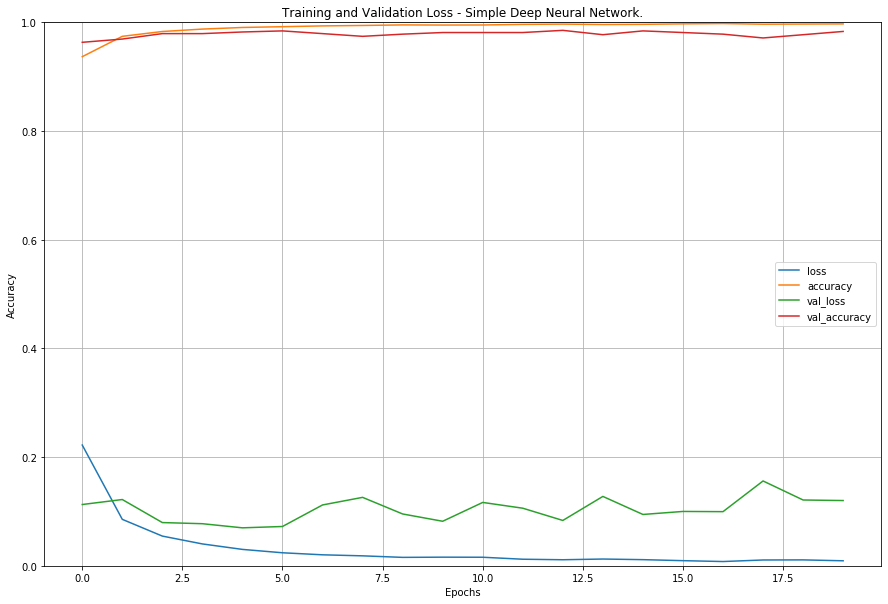

In [12]:
pd.DataFrame(history.history).plot(figsize=(15, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title("Training and Validation Loss - Simple Deep Neural Network.")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

---

<br>

<h2> 3.2 - GridSearchCV on Simple DNN </h2><br>

As a means of improving this initial basline model we utilised SKLearn's GridSearchCV object to automate the tuning of our hyperparamters. 

<h3><ins>3.2.1 - Parameter Initialisation</ins></h3><br>

First we had to build a parameter grid (normal SKLearn practice), setting up a range of different values for Grid Search to try in each parameter argument.

---

In [13]:
batch_size = [10, 20, 40]
epochs = [10, 50, 100]
learning_rate = [0.001, 0.01]
n_neurons = [10, 100, 150, 200]
momentum = [0.9, 0.8]

param_grid2 = dict(learning_rate=learning_rate, 
                 batch_size=batch_size, epochs=epochs, n_neurons=n_neurons,
                  momentum=momentum)

<br>

<h3><ins>3.2.2 - SKLearn Wrapper</ins></h3><br>

In order to use the built-in `.fit()` method of the GridSearchCV object, we need to wrap our model in a thin SKLearn wrapper. 

---

In [14]:
grid_model = keras.wrappers.scikit_learn.KerasClassifier(build_model)

<br>

<h3><ins>3.2.3 - Fit the GridSearch</ins></h3><br>

With the parameters initialised and the model wrapped we can go ahead and call the `.fit()` method. 

---

<br>

<i>Disclaimer: Please find outlined the parameters of the gridsearch, included here for posterity. This gridsearch ran overnight and produced the optimum parameters used to fit the Deep Neural Net below.</i>

<i>The following code was used to initialise the gridsearch and has been commented out for practical reasons.</i>

`new_grid = GridSearchCV(estimator=grid_model, param_grid=param_grid2, cv=3)
 result = new_grid.fit(X_train, y_train_one_hot, epochs=10,
                      validation_data=(X_valid, y_valid_one_hot),
                      callbacks=[keras.callbacks.EarlyStopping(patience=10)],
                      verbose=0)`

---





In [15]:
best_model = build_model(learning_rate=0.001, optimizer='nadam', n_neurons=150, momentum=0.8)
hist_best = best_model.fit(X_train, y_train_one_hot, epochs=30, batch_size=10, 
               callbacks=[keras.callbacks.EarlyStopping(patience=5),
                           tensorboard_cb], validation_data=(X_valid, y_valid_one_hot))

Train on 59000 samples, validate on 1000 samples
Epoch 1/30
59000/59000 [==============================] - 13s 227us/sample - loss: 0.4871 - accuracy: 0.8533 - val_loss: 0.1781 - val_accuracy: 0.9460
Epoch 2/30
59000/59000 [==============================] - 13s 225us/sample - loss: 0.2157 - accuracy: 0.9363 - val_loss: 0.1709 - val_accuracy: 0.9480
Epoch 3/30
59000/59000 [==============================] - 14s 239us/sample - loss: 0.1698 - accuracy: 0.9503 - val_loss: 0.1258 - val_accuracy: 0.9550
Epoch 4/30
59000/59000 [==============================] - 13s 225us/sample - loss: 0.1397 - accuracy: 0.9588 - val_loss: 0.1216 - val_accuracy: 0.9650
Epoch 5/30
59000/59000 [==============================] - 13s 226us/sample - loss: 0.1192 - accuracy: 0.9648 - val_loss: 0.1162 - val_accuracy: 0.9670
Epoch 6/30
59000/59000 [==============================] - 13s 225us/sample - loss: 0.1050 - accuracy: 0.9685 - val_loss: 0.1106 - val_accuracy: 0.9700
Epoch 7/30
59000/59000 [=====================

In [16]:
mse_test = best_model.evaluate(X_valid, y_valid_one_hot, verbose=0)

<br>

<h3><ins>3.2.4 - GridSearch Results</ins></h3><br>


After running overnight, `GridSearchCV` provided parameters that produced an optimial accuracy. 

Using those parameters we fit the above model and produced the following results.

We can see that by using optimised hyperparameters, we have somewhat mitigated the overfitting problem. This issue could be further solved with the inclusion of more data, data augmentation, reducing the model complexity or implementating a regularisation technique. 

We can also see the accuracy and validation accuracy converging faster, indicating that our tuned hyperparameters have produced a better fit for our data.  

<br>



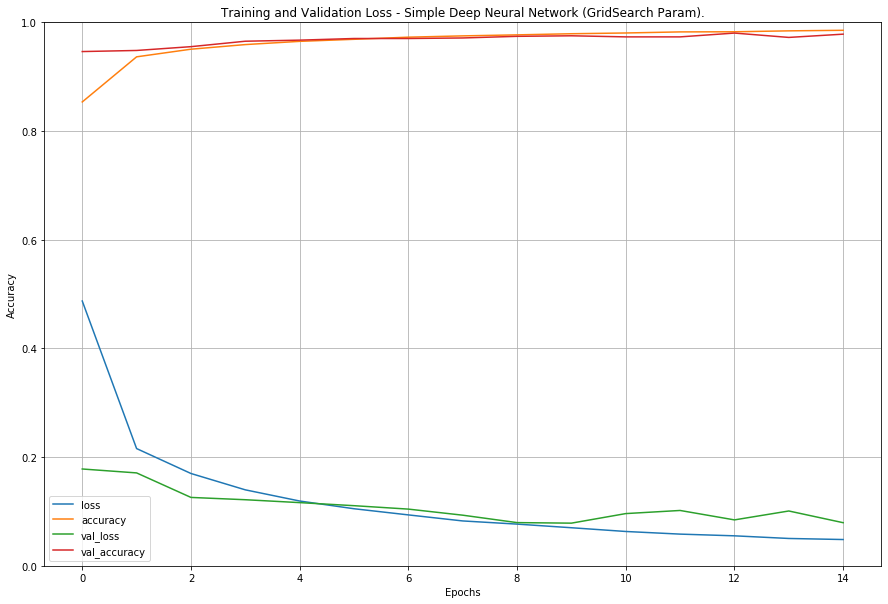

In [17]:
pd.DataFrame(hist_best.history).plot(figsize=(15, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title("Training and Validation Loss - Simple Deep Neural Network (GridSearch Param).")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

In [18]:
mse_test

[0.07929184051929042, 0.978]

By utislising the SKLearn's GridSearch object we have improved our classifcation score.

The following model scored `91%` on the unseen Kaggle data. 

--------

<br>


<h2>3.3 - Convolutional Neural Net - Initial Implementation </h2><br>


<h3><ins>3.3.1 Introduction</ins></h3><br>

After experimenting with a simple Deep Neural Net we then considered the use of a Convolutional Neural Network (CNN). This is due to it's traditionally high performance with image classification. 

The most important building block of a CNN are the convolutional layers, where each neuron is <b>not</b> connected to every single pixel in the input image, but only to those pixels within its receptive field. In turn the second convolutional layer is only connected by a small rectangle of neurons in the first layer. This allows the net to focus on small low-level features, assembling them into higher level features as the data moves through the network. Real-world images mirror this heirarchical structure, which is one of the reasons why CNN's work so well for image recognition.

In order to implement this type of network it was neccessary to pre-process the data into a format suitable for convolutional layers. 

<br>

<br>

<h3><ins>3.3.2 - Preprocessing the data </ins></h3><br>

Convolutional Neural Networks take images as inputs and use a `filter` (a small window of weights) to gradually move across the image (this is called the `stride`), creating a much smaller output vector for the next convolutional layer. 

Each convolutional layer is a 3d tensor; pixel height, pixel width and channel. Most  images in the real world have three channels ('RGB'), however our MNIST data only exists on a single channel, however we did need to reshape the data to reflect the original image dimensions. 



<br>

In [7]:
X_train_reshape = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_valid_reshape = X_valid.reshape((X_valid.shape[0], 28, 28, 1))
X_test_reshape = X_test.reshape((X_test.shape[0], 28, 28, 1))

<br>

<h3><ins>3.3.3 - CNN Architecture</ins></h3><br>

We included a `Max Pool` layer in this network. These layers do not have any weights, but instead return the maximum input value from each filter pass over that part of the image.

Although this is massively destructive, it preserves the <i>'brightest'</i> pixels and therefore the strongest features of the image. Here we have used a `pool size` of 2, so it divides each spatial dimension (`instances * features` or `features * filter_weights`) by a factor of 2. 

Finally, to help avoid overfitting, when the data reaches the fully connected network in the upper layers we have included `Dropout` after each activaiton. These layers will randomly "kill" some weights, setting their value to zero and thus negating any effect they have on the final prediction. 



![Illustration of SImple Deep Neural Network Architecture.](images/frank_cnn_1.png)

---

<br>

<h3><ins>3.3.4 - CNN Implementation</ins></h3><br>

We then constructed our first Convolutional Neural Network, fit the model with our reshaped data and recorded the result as our baseline accuracy. 

---

In [8]:
cnn_model = keras.models.Sequential([
    
    keras.layers.Conv2D(12, (7, 7), activation='relu', padding='same',
                       input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
      
])



In [9]:
cnn_model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [12]:

cnn_history = cnn_model.fit(X_train_reshape, y_train_one_hot, epochs=20, 
                        validation_data=(X_valid_reshape, y_valid_one_hot),
                        callbacks=[tensorboard_cb])

Train on 59000 samples, validate on 1000 samples
Epoch 1/20
59000/59000 [==============================] - 8s 131us/sample - loss: 0.0678 - accuracy: 0.9823 - val_loss: 0.0414 - val_accuracy: 0.9880
Epoch 2/20
59000/59000 [==============================] - 8s 129us/sample - loss: 0.0560 - accuracy: 0.9851 - val_loss: 0.0182 - val_accuracy: 0.9940
Epoch 3/20
59000/59000 [==============================] - 8s 128us/sample - loss: 0.0477 - accuracy: 0.9867 - val_loss: 0.0247 - val_accuracy: 0.9920
Epoch 4/20
59000/59000 [==============================] - 8s 128us/sample - loss: 0.0459 - accuracy: 0.9877 - val_loss: 0.0253 - val_accuracy: 0.9930
Epoch 5/20
59000/59000 [==============================] - 7s 127us/sample - loss: 0.0420 - accuracy: 0.9883 - val_loss: 0.0301 - val_accuracy: 0.9930
Epoch 6/20
59000/59000 [==============================] - 8s 130us/sample - loss: 0.0375 - accuracy: 0.9897 - val_loss: 0.0306 - val_accuracy: 0.9940
Epoch 7/20
59000/59000 [===========================

<br>


<h3><ins>3.3.5 - CNN1 Results</ins></h3><br>


The results from our first CNN were promising with an accuracy score of `99.1%`.

As we can see from the validation chart below, we have manaqed to further mitigate the overfitting problem from the previous Deep Neural Network. 

<br>

---

In [16]:
mse_cnn__test = cnn_model.evaluate(X_valid_reshape, y_valid_one_hot, verbose=0)
mse_cnn__test

[0.05898886369025325, 0.991]

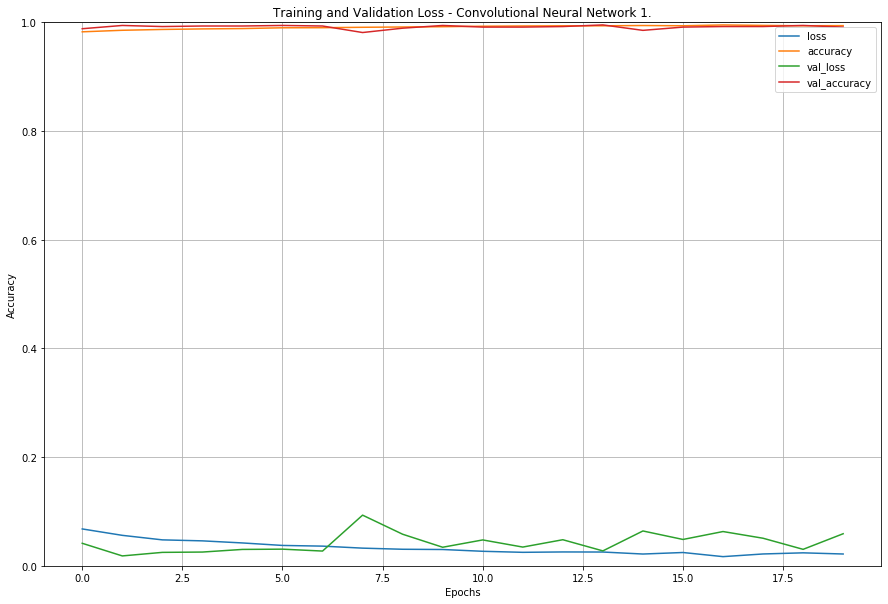

In [17]:
pd.DataFrame(cnn_history.history).plot(figsize=(15, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title("Training and Validation Loss - Convolutional Neural Network 1.")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

<br>

<h3><ins>3.3.6 - CNN1 Unseen Kaggle Data Results</ins></h3><br>

This implementation of a Convolutional Neural Net scored `95%` on the unseen Kaggle data.

---

<br>


<h2>3.4 - Deep Convolutional Neural Network </h2><br>


<h3><ins>3.4.1 Introduction</ins></h3><br>

In an attempt to futher increase our model accuracy we began to experiment with varying architectures of Convolutional Neural Networks. 

Increasing the number of convolutional layers led to a marked increase in accuracy, which we surmise is due to the ability of the net to build a more detailed picture of the image.

Also included in this implementation was `BatchNormalisation`. This process helps to alleviate the model's process of updating, layer-by-layer, using an estimate of the error. This error assumes the weights in the layers prior are fixed, and because all layers are changed during an update, the update procedure is always chasing a moving target. 

`BatchNormalisation` helps to coordinate the update of multiple layers in the model and is considered a 'de facto' part of any Deep Neural Network. 

Finally, for this Deep Convolutional Net, we opted for a `PReLU` (Parameteric ReLU) activation function, an adaption of the `LeakyReLU` acitvation function that allows the learning rate to be optimised using `gradient descent`. We also used an adjustable `Stochastic Gradient Descent` optimiser, with a tuned learning rate of `0.1`.

---


<h3><ins>3.4.2 Architecture</ins></h3><br>



![Illustration of SImple Deep Neural Network Architecture.](images/frank_dcnn.png)




<br>


<h3><ins>3.4.5 Instantiate the Model</ins></h3><br>

As outlined above we create our DCNN.



---

In [18]:
def build_model(input_shape=(28, 28, 1), num_classes = 10):
    input_layer = keras.layers.Input(shape=input_shape)
    cnn_model_aug = keras.models.Sequential([
        
    
    keras.layers.Conv2D(filters=8, kernel_size=(7, 7), padding="valid", name="conv1"),
    keras.layers.PReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(filters=16, kernel_size=(5, 5), padding="valid", name="conv2"),
    keras.layers.PReLU(),
    keras.layers.Dropout(0.5),
    keras.layers.MaxPooling2D(pool_size=(1, 1)),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="valid", name="conv3"),
    keras.layers.MaxPooling2D(pool_size=(1, 1)),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="valid", name="conv4"),
    keras.layers.MaxPooling2D(pool_size=(1, 1)),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(filters=128, kernel_size=(2, 2), padding="valid", name="conv5"),
    keras.layers.Conv2D(filters=64, kernel_size=(4, 4), padding="valid", name="conv6"),
    keras.layers.MaxPooling2D(pool_size=(1, 1)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(512, name="full1"),
    keras.layers.PReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, name="full2"),
    keras.layers.PReLU(),
    keras.layers.Dense(num_classes, activation='softmax'),
                              
                              ])
    


    return cnn_model_aug

In [19]:
fresh_model = build_model()

In [20]:
sgd = keras.optimizers.SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False)
fresh_model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [24]:
dcnn_history = fresh_model.fit(X_train_reshape, y_train_one_hot, epochs=10000,batch_size=32,
                        validation_data=(X_valid_reshape, y_valid_one_hot),
                        callbacks=[tensorboard_cb, keras.callbacks.EarlyStopping(patience=8)])

Train on 59000 samples, validate on 1000 samples
Epoch 1/10000
59000/59000 [==============================] - 13s 227us/sample - loss: 0.1220 - accuracy: 0.9630 - val_loss: 0.0415 - val_accuracy: 0.9870
Epoch 2/10000
59000/59000 [==============================] - 13s 223us/sample - loss: 0.1053 - accuracy: 0.9678 - val_loss: 0.0774 - val_accuracy: 0.9790
Epoch 3/10000
59000/59000 [==============================] - 13s 220us/sample - loss: 0.0921 - accuracy: 0.9723 - val_loss: 0.0694 - val_accuracy: 0.9790
Epoch 4/10000
59000/59000 [==============================] - 14s 232us/sample - loss: 0.0867 - accuracy: 0.9732 - val_loss: 0.0466 - val_accuracy: 0.9850
Epoch 5/10000
59000/59000 [==============================] - 13s 219us/sample - loss: 0.0784 - accuracy: 0.9761 - val_loss: 0.0515 - val_accuracy: 0.9850
Epoch 6/10000
59000/59000 [==============================] - 13s 223us/sample - loss: 0.0698 - accuracy: 0.9784 - val_loss: 0.0427 - val_accuracy: 0.9890
Epoch 7/10000
59000/59000 [

<br>


<h3><ins>3.4.5 DCNN Results</ins></h3><br>

Our Deep Convolutional Network performed well on the validation data at `98%`, while also resulting in one of our highest scores on the unseen Kaggle data at `96%`.

<br>

In [25]:
mse_dcnn__test = fresh_model.evaluate(X_valid_reshape, y_valid_one_hot, verbose=0)
mse_dcnn__test

[0.05157794326357543, 0.983]

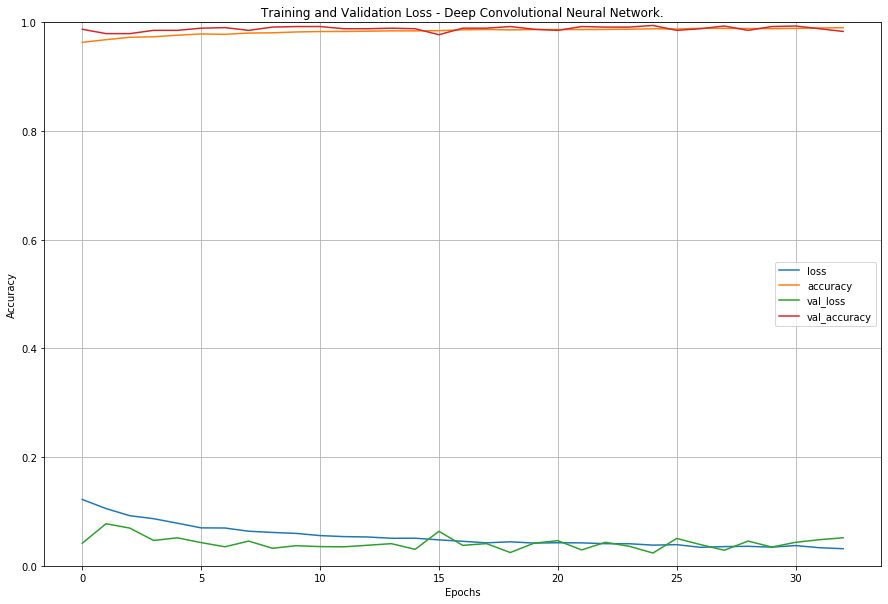

In [26]:
pd.DataFrame(dcnn_history.history).plot(figsize=(15, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title("Training and Validation Loss - Deep Convolutional Neural Network.")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

## 3.4 Custom ConvNet with regularization

### 3.4.1 - Introduction


This is also a custom 13 layer Convolutional Neural Net, but here we have attempted to use `regularisation` techniques to make a better generalisation on the output, although this particular model didn't perform spectacularly on the first 30% of the kaggle data.

---

### 3.4.2 Import Modules
---


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import np_utils
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, Dense, Flatten, BatchNormalization, MaxPooling2D,LeakyReLU
from tensorflow.keras.optimizers import RMSprop,Nadam,Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

import warnings
warnings.filterwarnings('ignore')

import os

<br>

Here we check that `Tensorflow` is accessing our GPU. 


<br>

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

### 3.4.3 Reading the data <br>

The data is loaded from the original csv files.


<br>



In [4]:
raw_train = pd.read_csv('../data/kannada_mnist/cs98x-kannada-mnist/training.csv')
raw_test = pd.read_csv('../data/kannada_mnist/cs98x-kannada-mnist/test.csv')

### 3.4.4 Preprocess Data with Visual <br>

As mentioned above, the preprocessing steps required for MNIST are minimal compared to other machine learning projects, with less scope for feature engineering or extraction. 

For posterity we visualise a sample of the data before `normalising` the pixels. 

---


Picture of 6 in Kannada


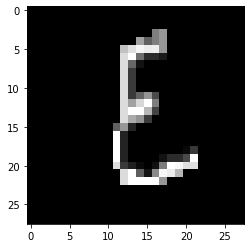

In [5]:
num=6
number = raw_train.iloc[num,2:].values.reshape(28,28)
print("Picture of "+ str(num) + " in Kannada")
plt.imshow(number, cmap=plt.get_cmap('gray'))
plt.show()


In [6]:
x = raw_train.iloc[:, 2:].values.astype('float32') / 255
y = raw_train.iloc[:, 1] # labels

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state=42) 

In [8]:
x_train.shape

(48000, 784)

In [9]:
x_train = x_train.reshape(-1, 28, 28,1)
x_val = x_val.reshape(-1, 28, 28,1)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

### 3.4.5 Defining the model
---

After many experimental attempts we achieved optimal convergence with the following architecture, by implementing strategies such as `batch normalization` and `dropout`. The `momentum` chosen below is random, however tuning this parameter had no noticible effect on the convergence capabilities of the model.

<br>


In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(64,  (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(64,  (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),    
    
    tf.keras.layers.Conv2D(256, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(256, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),##
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.LeakyReLU(alpha=0.1),
 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [11]:
optimizer = RMSprop(learning_rate=0.002,###########optimizer = RMSprop(learning_rate=0.0025,###########
    rho=0.9,
    momentum=0.1,
    epsilon=1e-07,
    centered=True,
    name='RMSprop')
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [12]:
batch_size = 64
num_classes = 10
epochs = 40

### 3.4.6 Doing data Augmentation
---


As a means of improving our model we used `data augmentation`, the process of transforming our orginal images across multiple dimensions in an attempt to encourage better generalisation. 

The transformation operations we performed are as follows: <br>

`rotation `: Randomly rotate the images around the center by a maximum of 15 degrees <br>
`width shift`: Move the image slightly out of frame on the horizontel axis, resulting in partial visibility<br>
`height shift`: Move the image slightly out of frame on the vertical axis, resulting in partial visibililty<br>
`zooming`: Zoom in and out of the image so certain features get amplified.<br>
 
We used built-in `Tensorflow` objects (such as the `ImageDataGenerator`) to perform these augmentations. 

This new data is then added to our original dataset and another model is trained using our increased image set. 

 
<br>

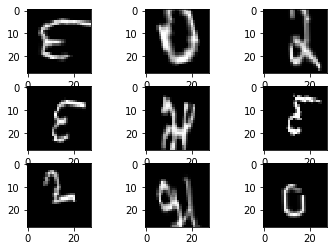

In [13]:

datagen_try = ImageDataGenerator(rotation_range=15,
                             width_shift_range = 0.15,
                             height_shift_range = 0.15,
                             shear_range = 0.15,
                             zoom_range = 0.4,)
# fit parameters from data
datagen_try.fit(x_train)
# configure batch size and retrieve one batch of images
for x_batch, y_batch in datagen_try.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(x_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    plt.show()
    break

In [14]:
datagen_train = ImageDataGenerator(rotation_range = 10,
                                   width_shift_range = 0.25,
                                   height_shift_range = 0.25,
                                   shear_range = 0.1,
                                   zoom_range = 0.4,
                                   horizontal_flip = False)

datagen_val = ImageDataGenerator() 


step_train = x_train.shape[0] // batch_size
step_val = x_val.shape[0] // batch_size

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau( 
    monitor='loss',    # Quantity to be monitored.
    factor=0.25,       # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=2,        # The number of epochs with no improvement after which learning rate will be reduced.
    verbose=1,         # 0: quiet - 1: update messages.
    mode="auto",       # {auto, min, max}. In min mode, lr will be reduced when the quantity monitored has stopped decreasing; 
                       # in the max mode it will be reduced when the quantity monitored has stopped increasing; 
                       # in auto mode, the direction is automatically inferred from the name of the monitored quantity.
    min_delta=0.0001,  # threshold for measuring the new optimum, to only focus on significant changes.
    cooldown=0,        # number of epochs to wait before resuming normal operation after learning rate (lr) has been reduced.
    min_lr=0.00001     # lower bound on the learning rate.
    )

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300, restore_best_weights=True)

In [15]:
history = model.fit(datagen_train.flow(x_train, y_train, batch_size=batch_size),
                              steps_per_epoch=len(x_train)//batch_size,
                              epochs=epochs,
                              validation_data=(x_val, y_val),
                              validation_steps=50,
                              callbacks=[learning_rate_reduction, es],
                              verbose=2)

  ...
    to  
  ['...']
Train for 750 steps, validate on 12000 samples
Epoch 1/40
750/750 - 21s - loss: 0.4728 - accuracy: 0.8453 - val_loss: 0.0241 - val_accuracy: 0.9728
Epoch 2/40
750/750 - 18s - loss: 0.1863 - accuracy: 0.9388 - val_loss: 0.0140 - val_accuracy: 0.9847
Epoch 3/40
750/750 - 18s - loss: 0.1520 - accuracy: 0.9517 - val_loss: 0.0156 - val_accuracy: 0.9837
Epoch 4/40
750/750 - 18s - loss: 0.1308 - accuracy: 0.9580 - val_loss: 0.0101 - val_accuracy: 0.9916
Epoch 5/40
750/750 - 18s - loss: 0.1183 - accuracy: 0.9622 - val_loss: 0.0068 - val_accuracy: 0.9934
Epoch 6/40
750/750 - 18s - loss: 0.1074 - accuracy: 0.9658 - val_loss: 0.0082 - val_accuracy: 0.9922
Epoch 7/40
750/750 - 18s - loss: 0.1052 - accuracy: 0.9653 - val_loss: 0.0079 - val_accuracy: 0.9928
Epoch 8/40
750/750 - 18s - loss: 0.0967 - accuracy: 0.9687 - val_loss: 0.0071 - val_accuracy: 0.9934
Epoch 9/40
750/750 - 18s - loss: 0.0948 - accuracy: 0.9702 - val_loss: 0.0069 - val_accuracy: 0.9928
Epoch 10/40
750/750

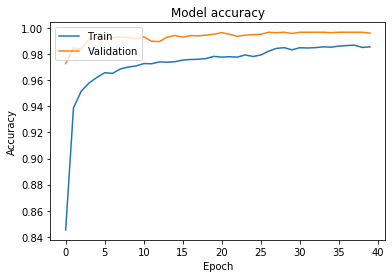

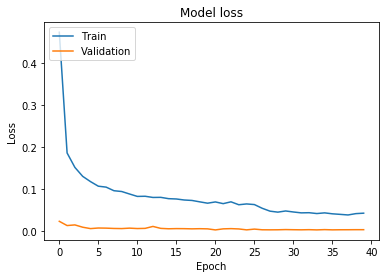

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Results of the model


### 3.4.7 Test Set Accuracy Score <br>

The additional data augmentation increased our performance by three percent on the unseen data

In [17]:
model.evaluate(x_val, y_val, verbose=2);

12000/12000 - 2s - loss: 0.0146 - accuracy: 0.9958


### 3.4.8 Confusion Matrix

The confusion matrix below shows the ground truth value vs. the predicted value of the model. A straight like-colored diagonal line across the center means we have a good fitting model at hand

In [22]:
y_predicted = model.predict(x_val)
y_ground_truth = y_val
y_predicted = np.argmax(y_predicted,axis=1)
y_ground_truth = np.argmax(y_ground_truth,axis=1)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_ground_truth, y_predicted)

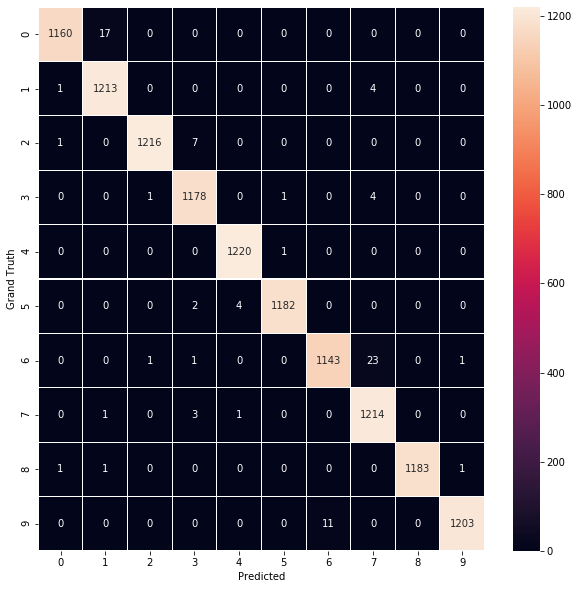

In [27]:
import seaborn as sns
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm,fmt=".0f", annot=True,linewidths=0.01, ax=ax)
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.show()

In [28]:
scores = np.zeros((10,3))
def calc_F1(num):
  TP = cm[num,num]
  FN = np.sum(cm[num,:])-cm[num,num]
  FP = np.sum(cm[:,num])-cm[num,num]
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  F1_score = 2*(recall * precision) / (recall + precision)
  return precision, recall, F1_score
for i in range(10):
   precision, recall, F1_score = calc_F1(i)
   scores[i,:] = precision, recall, F1_score
scores_frame = pd.DataFrame(scores,columns=["Precision", "Recall", "F1 Score"], index=[list(range(0, 10))])

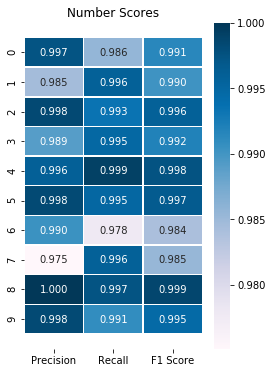

In [29]:
f, ax = plt.subplots(figsize = (4,6))
ax.set_title('Number Scores')
sns.heatmap(scores_frame, annot=True, fmt=".3f", linewidths=0.5, cmap="PuBu", cbar=True, ax=ax)
bottom, top = ax.get_ylim()
plt.ylabel("")
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

### 3.4.9 Submit for Competition


In [ ]:
sample_sub=pd.read_csv('../data/kannada_mnist/cs98x-kannada-mnist/test.csv')
raw_test_id=raw_test.id
raw_test=raw_test.drop("id",axis="columns")
raw_test=raw_test / 255
test=raw_test.values.reshape(-1,28,28,1)
test.shape

In [23]:
sub=model.predict(test)     ##making prediction
sub=np.argmax(sub,axis=1) ##changing the prediction intro labels

sample_sub['label']=sub
sample_sub.to_csv('scratch_model_apr_6.csv',index=False)

## 3.5 Experimenting with pre trained models: The fastai library

### 3.5.1 Introduction
---

In this section we explore the method of fitting the data on a pre- trained network by unfreezing the last few layers. The fastai library is a robust deep learning library built on top of PyTorch that creates a high level abstraction for easy model building and experimentation. 

It also comes with a unique tool that helps to find an ideal learning rate called the `lr_finder`. This tool greatly reduces the need to rely on functions such as `GridSearchCV` to tediously experiment with learning rates. 

The fastai library is also capable of exporting the model directly for production use.

### 3.5.2 ResNet50  - Best Performing Model <br>

In this section, we experiment with training resnet50 using the fastai library.

<br>

In [56]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [57]:
from fastai import *
from fastai.vision import *
import imageio
import numpy as np 
import pandas as pd 

In [58]:
path = Path('../data/kannada_mnist/')
train = pd.read_csv('../data/kannada_mnist/cs98x-kannada-mnist/training.csv')
test  =pd.read_csv('../data/kannada_mnist/cs98x-kannada-mnist/test.csv')

### 3.5.3 Converting the pixel values to actual images
<br>
We chose to convert the pixel values to actual images, that way we can play around with parameters such as resolution and size.


<br>


In [59]:
def to_img_shape(data_X, data_y=[]):
    data_X = np.array(data_X).reshape(-1,28,28)
    data_X = np.stack((data_X,)*3, axis=-1)
    data_y = np.array(data_y)
    return data_X,data_y

### 3.5.4 Splitting the data  <br>

We define this function once, future model experimentations involved experimenting with differing validation sizes.

<br>

In [60]:
data_X, data_y = train.loc[:,'pixel0':'pixel783'], train['label']

In [61]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(data_X, data_y, test_size=0.10,random_state=7,stratify=data_y)

In [62]:
train_X,train_y = to_img_shape(train_X, train_y)
val_X,val_y = to_img_shape(val_X,val_y)

In [63]:
tfms = get_transforms(do_flip=False, max_rotate=15, max_zoom=1.15, max_warp=0.05, max_lighting=0.1)

In [64]:
data = (ImageList.from_folder('../data/kannada_mnist/') 
        .split_by_folder()          
        .label_from_folder()        
        .add_test_folder()          
        .transform(tfms, size=64)   
        .databunch())

### 3.5.5 Viewing the databunch
---
Let's view 9 images from our dataset after we've aplied the transforms to them. In this instalce we have a new paramer that can also change the lighting of the image, meaning we can make the whites brighter.

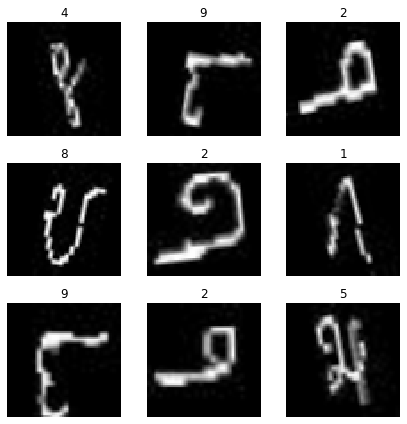

In [65]:
data.show_batch(3,figsize=(6,6))

### 3.5.6 Setting the pretrained model to resnet50

In [66]:
learn = cnn_learner(data, models.resnet50, metrics=[error_rate, accuracy])

### 3.5.7 Finding the learning rate <br>

As we can see from the graph below, the lowest learning rate that yeilds the least loss is around `(1e-02)` to `(1e-01)`. We shall use this to set the learning rate for the model to make it converge faster.

<br>

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


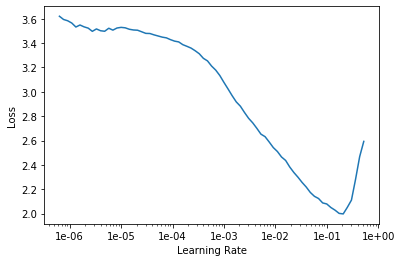

In [67]:
learn.lr_find()
learn.recorder.plot()

### 3.5.8 Fitting one cycle policy <br>

The motivation behind this is that, during the middle of learning, when learning rate is higher, it works as a regularisation method to keep the network from overfitting. 

This helps the network avoid steep areas of loss and find a better, flatter minima. 

More details of the logic can be found here : https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6 .

<br>

In [68]:
lr = 1e-2
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.313900,0.162462,0.048500,0.951500,00:48
1,0.124778,0.059305,0.016833,0.983167,00:47
2,0.076736,0.041638,0.011500,0.988500,00:47
3,0.065121,0.036711,0.011667,0.988333,00:48


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


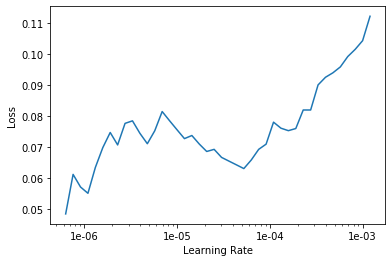

In [69]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [70]:
lr = 2e-6
learn.fit_one_cycle(5,lr)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.065940,0.034828,0.010667,0.989333,01:08
1,0.058177,0.032919,0.009167,0.990833,01:09
2,0.042502,0.029718,0.009167,0.990833,01:09
3,0.043998,0.029039,0.008667,0.991333,01:09
4,0.042512,0.028793,0.008500,0.991500,01:09


In [71]:
learn.save('stage-2')

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


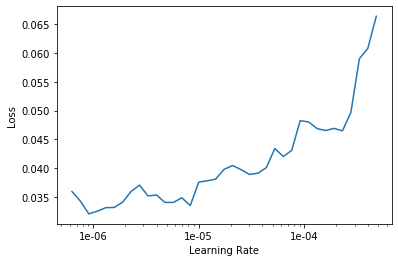

In [72]:
learn.lr_find()
learn.recorder.plot()

In [73]:
lr = slice(2e-6)
learn.fit_one_cycle(3,lr)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.044162,0.029110,0.009333,0.990667,01:09
1,0.041479,0.029199,0.008500,0.991500,01:09
2,0.039822,0.028140,0.008167,0.991833,01:09


### 3.5.9 Submitting to Kaggle <br>

With out best model tuned we made predictions on the unseen Kaggle data.

<br>

In [74]:
test_csv = pd.read_csv('../data/kannada_mnist/cs98x-kannada-mnist/test.csv')
test_csv.drop('id',axis = 'columns',inplace = True)
sub_df = pd.DataFrame(columns=['id','label'])

In [75]:
test_data = np.array(test_csv)

In [76]:
def get_img(data):
    t1 = data.reshape(28,28)/255
    t1 = np.stack([t1]*3,axis=0)
    img = Image(FloatTensor(t1))
    return img

In [77]:
from fastprogress import progress_bar
mb=progress_bar(range(test_data.shape[0]))

for i in mb:
    timg=test_data[i]
    img = get_img(timg)
    sub_df.loc[i]=[i+1,int(learn.predict(img)[1])]

In [78]:
def decr(ido):
    return ido-1

sub_df['id'] = sub_df['id'].map(decr)
sub_df.to_csv('submission_resnet50_tuned_15032020_2.csv',index=False)

### 3.5.10 Results <br>


This model performed quite well, achieving a very low error rate and a good accuracy. The training time is also extremeley efficient (one of the main advantages of using a pretrained model).

<br>


## 3.6 ResNet 50 with a 15 % validation set

We chose 15% as the validation set size because its very comparable to the size of the actual unseen data. An accuarcy estimate on this model should give us a good idea on how well the model will generalise in real scenarios.

Below we followed the same steps but with the change in validation ratio. 

<br>

In [5]:
data_X, data_y = train.loc[:,'pixel0':'pixel783'], train['label']

In [6]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(data_X, data_y, test_size=0.15,random_state=5,stratify=data_y)

In [7]:
train_X,train_y = to_img_shape(train_X, train_y)
val_X,val_y = to_img_shape(val_X,val_y)

In [8]:
tfms = get_transforms(do_flip=True, max_rotate=15, max_zoom=1.15, max_warp=0.05, max_lighting=0.1)

In [9]:
data = (ImageList.from_folder('../data/kannada_mnist/') 
        .split_by_folder()          
        .label_from_folder()        
        .add_test_folder()          
        .transform(tfms, size=32)   
        .databunch())

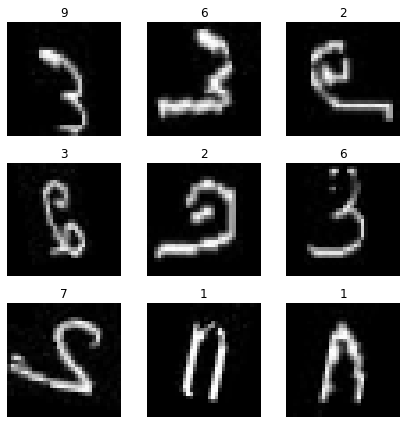

In [10]:
data.show_batch(3,figsize=(6,6))

In [11]:
learn = cnn_learner(data, models.resnet50, metrics=[error_rate, accuracy])

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


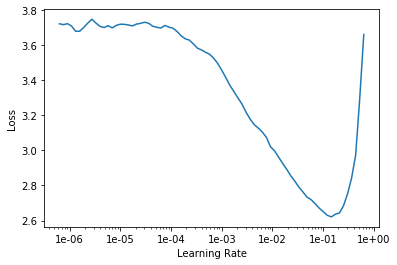

In [12]:
learn.lr_find()
learn.recorder.plot()

### 3.6.1 Unfreezing and fitting to one cycle <br>

<br>

In [13]:
lr = slice(1e-02,1e-01)
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.720356,0.479237,0.150000,0.850000,00:30
1,0.296366,0.183739,0.060667,0.939333,00:30
2,0.205060,0.113973,0.035500,0.964500,00:30
3,0.171403,0.106375,0.033667,0.966333,00:30


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


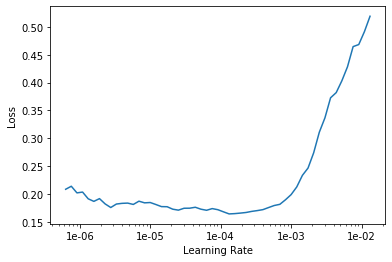

In [14]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

### 3.6.3 fitting 5 cycles with a sliced learning rate <br>

Here we ask the algorithm to gradually change the learning rate, but only between predefined boundaries.

<br>

In [15]:
lr = slice(2e-6,2e-3)
learn.fit_one_cycle(5,lr)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.152196,0.091872,0.027167,0.972833,00:45
1,0.112092,0.063268,0.018167,0.981833,00:45
2,0.068831,0.041692,0.012167,0.987833,00:45
3,0.048239,0.028677,0.009167,0.990833,00:46
4,0.040751,0.028229,0.009000,0.991000,00:45


In [16]:
learn.save('stage-2')

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


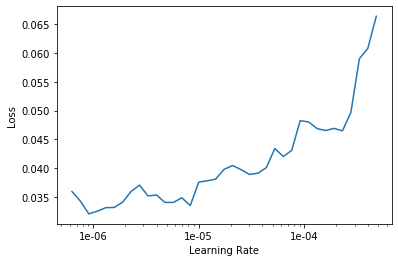

In [72]:
learn.lr_find()
learn.recorder.plot()

In [73]:
lr = slice(2e-6)
learn.fit_one_cycle(3,lr)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.044162,0.029110,0.009333,0.990667,01:09
1,0.041479,0.029199,0.008500,0.991500,01:09
2,0.039822,0.028140,0.008167,0.991833,01:09


### 3.6.4 Submit to kaggle <br>

With another model tuned, we then made a further prediction submission to Kaggle. 

This model achieved our highest score of `98%`.

<br>

In [17]:
test_csv = pd.read_csv('../data/kannada_mnist/cs98x-kannada-mnist/test.csv')
test_csv.drop('id',axis = 'columns',inplace = True)
sub_df = pd.DataFrame(columns=['id','label'])

In [18]:
test_data = np.array(test_csv)

In [19]:
def get_img(data):
    t1 = data.reshape(28,28)/255
    t1 = np.stack([t1]*3,axis=0)
    img = Image(FloatTensor(t1))
    return img

In [20]:
from fastprogress import progress_bar
mb=progress_bar(range(test_data.shape[0]))

for i in mb:
    timg=test_data[i]
    img = get_img(timg)
    sub_df.loc[i]=[i+1,int(learn.predict(img)[1])]

In [24]:
def decr(ido):
    return ido-1

sub_df['id'] = test_csv['id']
sub_df.to_csv('submission_resnet50_tuned_21032020.csv',index=False)

## 4 Evaluations and conclusions
---



The best performing model on the Kaggle data (first 30% )was the model we built by manually adding in layers.The second best was the pre-trained model (ResNet 50) with the fastai library. We found that data augmentation helped a great deal with boosting the training accuracy. 

Also saving the tensors as images to disk seems like a good option to expunge the noise while loading images into the model. We also experimented with a pre-trained model that had many layers, but that led to overfitting and a very long training time. 
